# Milwaukee vs Portland

## Introduction

I live in Milwaukee and for business I have traveled to the west coast quite a bit, specifically to Portland. I remember running across this article: https://www.salon.com/2014/08/20/milwaukee_is_the_new_portland_partner and wondering - is this really true? They do feel similar, but what does the data say? Do they have similarities in the make-up of their neighborhoods? This project will explore similarities and differences of the distinct make-up of both cities at the neighborhood and city-wide level by describing and clustering neighborhoods by venue types using a K-Means clustering algorithm and exploring the frequencies of occurance of discrete venue types. We will compare and contrast the results of our findings.

We will be exploring the neighborhoods using a combination of FourSquare's APIs for venues and locations with a combination of open source datasets to define our neighborhoods.

- https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Milwaukee - we will use this list as the index of neighborhoods in Milwaukee
- https://portlandneighborhood.com/portlandzipcodes - we will use this data to identity and come up with centroids for our Portland neighborhoods
- https://developer.mapquest.com/documentation/open/geocoding-api/address/get/ -open source geocoder

## Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge beautifulsoup4 -y
!conda install -c conda-forge shapely -yes

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Portland
### Model Neighborhoods and Cluster them
#### Get the neighborhood table

In [127]:
!wget -q -O 'pdx_nbh.html' https://portlandneighborhood.com/portlandzipcodes
print('Download finished')

Download finished


#### Parse the HTML table, call Geocoder for lat/lng data and insert them into a dataframe

In [128]:
from bs4 import BeautifulSoup
OPENMAPKEY = 'VXxN7UxBp8JBSPdHmtA47yOABeFy4Zws'
OPENMAP_GCAPI = 'http://open.mapquestapi.com/geocoding/v1/address?key='+OPENMAPKEY+'&location={0},PORTLAND,OR'


with open("pdx_nbh.html") as pdxHtml:
    soup = BeautifulSoup(pdxHtml)
    table = soup.find_all('table')[0]
    row_count = len(table.find_all('tr'))
    
    df = pd.DataFrame(columns=["Neighborhood","Latitude","Longitude"],index=range(0,row_count))
    
    row_marker = 0
    for row in table.find_all('tr'):
        column = row.find_all('td')[0]
        colText = column.get_text().replace('View the ','').replace(' Neighborhood profile','').replace('Neighborhood profile','')
        df.iat[row_marker,0] = colText
        response = requests.get(OPENMAP_GCAPI.format(colText)) #geocoder call
        if response.status_code == 200:
            jsonResp = json.loads(response.content.decode('utf-8'))
            lat = jsonResp['results'][0]['locations'][0]['latLng']['lat']
            long = jsonResp['results'][0]['locations'][0]['latLng']['lng']
            print('Hood: ', colText, 'Lat: ', lat, ' Long: ', long)
            df.iat[row_marker,1] = lat
            df.iat[row_marker,2] = long
            
        row_marker +=1
            
df

Hood:  Alameda Lat:  45.548631  Long:  -122.636481
Hood:  Arbor Lodge Lat:  45.571794  Long:  -122.690152
Hood:  Ardenwald Lat:  45.46419  Long:  -122.638301
Hood:  Argay Lat:  45.55283  Long:  -122.523204
Hood:  Arlington Heights Lat:  45.519496  Long:  -122.710667
Hood:  Arnold Creek Lat:  45.444312  Long:  -122.712609
Hood:  Ash Creek Lat:  45.461347  Long:  -122.74238
Hood:  Beaumont Wilshire Lat:  45.550391  Long:  -122.623694
Hood:  Boise Lat:  45.550159  Long:  -122.671878
Hood:  Brentwood Darlington Lat:  45.468707  Long:  -122.597633
Hood:  Bridgeton Lat:  45.602409  Long:  -122.668102
Hood:  Bridlemile Lat:  45.492559  Long:  -122.726693
Hood:  Brooklyn Lat:  45.494819  Long:  -122.651552
Hood:  Buckman Lat:  45.517381  Long:  -122.651954
Hood:  Centennial Lat:  45.505595  Long:  -122.499711
Hood:  Center Lat:  45.520247  Long:  -122.674195
Hood:  Collins View Lat:  45.457979  Long:  -122.68121
Hood:  Concordia Lat:  45.565866  Long:  -122.632216
Hood:  Corbett Terwilliger La

Neighborhood Latitude Longitude
0                         Alameda  45.5486  -122.636
1                     Arbor Lodge  45.5718   -122.69
2                       Ardenwald  45.4642  -122.638
3                           Argay  45.5528  -122.523
4               Arlington Heights  45.5195  -122.711
5                    Arnold Creek  45.4443  -122.713
6                       Ash Creek  45.4613  -122.742
7               Beaumont Wilshire  45.5504  -122.624
8                           Boise  45.5502  -122.672
9            Brentwood Darlington  45.4687  -122.598
10                      Bridgeton  45.6024  -122.668
11                     Bridlemile  45.4926  -122.727
12                       Brooklyn  45.4948  -122.652
13                        Buckman  45.5174  -122.652
14                     Centennial  45.5056    -122.5
15                         Center  45.5202  -122.674
16                   Collins View   45.458  -122.681
17                      Concordia  45.5659  -122.632
18  Corbett Terwilliger Lair Hill  39.7837  -100.446
19             Creston Kenilworth  45.4937  -122.623
20                      Crestwood  45.4508  -122.737
21                          Cully  45.5615  -122.602
22              Downtown Portland  45.5153   -122.68
23                  East Columbia  45.5938  -122.664
24                   Eastmoreland  45.4736  -122.631
25                          Eliot  45.5412  -122.668
26                  Far Southwest  45.4399  -122.736
27                    Forest Park  45.5358  -122.739
28                  Foster Powell  45.4932  -122.589
29                 Cathedral Park  45.5876  -122.759
30                       Glenfair  45.5227  -122.504
31                   Goose Hollow  45.5177  -122.693
32                     Grant Park  45.5401  -122.628
33                  Hayden Island  45.6111  -122.679
34                       Hayhurst  45.4815  -122.729
35                      Hazelwood  45.5239  -122.538
36                  Healy Heights  45.4925  -122.699
37                      Hillsdale  45.4786  -122.695
38                       Hillside  45.5274  -122.713
39                      Hollywood  45.5359   -122.62
40                      Homestead   45.496  -122.687
41              Hosford Abernethy  45.5066  -122.649
42                       Humboldt  45.5605  -122.671
43                      Irvington   45.542  -122.649
44                         Kenton  45.5831  -122.693
45                          Kerns  45.5268  -122.645
46                           King  45.5578  -122.658
47                    Laurelhurst  45.5265  -122.624
48                          Lents  45.4797  -122.565
49                        Linnton  45.6003  -122.787
50                 Lloyd District  45.5314   -122.66
51                  Madison South   45.541  -122.573
52                      Maplewood  45.4719  -122.734
53                        Markham  45.4584  -122.704
54                  Marshall Park  45.4535  -122.696
55                      Mill Park  45.5116  -122.539
56                     Montavilla  45.5191  -122.576
57                Mt Scott Arleta  45.4814  -122.591
58                       Mt Tabor  45.5158    -122.6
59                      Multnomah  45.4662  -122.713
60                      Northwest  45.5052  -122.611
61              Northwest Heights  45.5408  -122.774
62  Portland Northwest Industrial  39.7837  -100.446
63             Old Town Chinatown  45.5249  -122.674
64                       Overlook  45.5591  -122.692
65               Parkrose Heights  45.5402  -122.548
66                       Parkrose  45.5575  -122.551
67                 Pearl District   45.529  -122.682
68                       Piedmont  45.5746  -122.669
69                Pleasant Valley   45.472  -122.507
70                     Portsmouth   45.588  -122.719
71            Powellhurst Gilbert  45.4926  -122.539
72                           Reed  45.4851  -122.632
73                       Richmond  45.5047  -122.623
74                 Rose City Park  45.5384  -1

#### Get venues

In [129]:
# defining looping explore function from earlier New York Lab
CLIENT_ID = '3IE0XCO1MOEFL0YKGWLBDB2DHGN42KB2DD5ZLC52NJTF5EDC' # your Foursquare ID
CLIENT_SECRET = '5JIIATBSQIPVBWKR2BF1MOQ4P5SS1J4EYSXWHHXENXRZT4HH'  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
limit = 300

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        json = requests.get(url).json()
        print(json)
        results = json["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [130]:
pdx_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Alameda
{'meta': {'code': 200, 'requestId': '5dbdb768db1d81002c769be3'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Alameda', 'headerFullLocation': 'Alameda, Portland', 'headerLocationGranularity': 'neighborhood', 'totalResults': 6, 'suggestedBounds': {'ne': {'lat': 45.5531310045, 'lng': -122.6300672070211}, 'sw': {'lat': 45.5441309955, 'lng': -122.64289479297891}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5908a538002f4c7894e0e5ca', 'name': 'Guilder', 'location': {'address': '2393 NE Fremont St', 'lat': 45.54829, 'lng': -122.641335, 'labeledLatLngs': [{'label': 'display', 'lat': 45.54829, 'lng': -122.641335}], 'distance': 380, 'postalCode': '97212', 'cc': 'US', 'city': 'Portland', 'state': 'OR', 'country': 'United S

In [136]:
# one hot encoding
pdx_onehot = pd.get_dummies(pdx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pdx_onehot['Neighborhood'] = pdx_venues['Neighborhood'] 

# move neighborhood column to the first column
nbh = pdx_onehot['Neighborhood']
pdx_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
pdx_onehot.insert(0, 'Neighborhood', nbh)

pdx_onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  American Restaurant  \
0      Alameda    0                  0               0                    0   
1      Alameda    0                  0               0                    0   
2      Alameda    0                  0               0                    0   
3      Alameda    0                  0               0                    0   
4      Alameda    0                  0               0                    0   

   Amphitheater  Antique Shop  Arcade  Art Gallery  Art Museum  \
0             0             0       0            0           0   
1             0             0       0            0           0   
2             0             0       0            0           0   
3             0             0       0            0           0   
4             0             0       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auto Dealership  Auto Garage  Auto Workshop  \
0                   0                0            0              0   
1                   0                0            0              0   
2                   0                0            0              0   
3                   0                0            0              0   
4                   0                0            0              0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0                 0                0         0           0   
1                 0                 0                0         0           0   
2                 0                 0                0         0           0   
3                 0                 0                0         0           0   
4                 0                 0                0         0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Board Shop  Bookstore  \
0              0                         0          0           0          0   
1              0                         0          0           0          0   
2              0                         0          0           0          0   
3              0                         0          0           0          0   
4              0                         0          0           0          0   

   Botanical Garden  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0                 0         0                     0               0        0   
1                 0         0                     0               0        0   
2                 0         0                     0               0        0   
3                 0         0                     0               0        0   
4                 0         0                     0               0        0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         0             0              0         0   
2                0         0             0              0         0   
3                0         0             0              0         0   
4                0         0     

In [137]:
pdx_grouped = pdx_onehot.groupby('Neighborhood').mean().reset_index()
pdx_grouped

Neighborhood       ATM  Accessories Store  Adult Boutique  \
0                Alameda  0.000000           0.000000             0.0   
1            Arbor Lodge  0.000000           0.000000             0.0   
2              Ardenwald  0.000000           0.000000             0.0   
3                  Argay  0.000000           0.000000             0.0   
4      Arlington Heights  0.000000           0.000000             0.0   
5           Arnold Creek  0.000000           0.000000             0.0   
6              Ash Creek  0.000000           0.000000             0.0   
7      Beaumont Wilshire  0.000000           0.000000             0.0   
8                  Boise  0.000000           0.000000             0.0   
9   Brentwood Darlington  0.000000           0.000000             0.0   
10             Bridgeton  0.000000           0.000000             0.0   
11            Bridlemile  0.000000           0.000000             0.0   
12              Brooklyn  0.000000           0.000000             0.0   
13               Buckman  0.000000           0.000000             0.0   
14        Cathedral Park  0.025641           0.000000             0.0   
15            Centennial  0.066667           0.000000             0.0   
16                Center  0.000000           0.000000             0.0   
17          Collins View  0.000000           0.000000             0.0   
18             Concordia  0.000000           0.028571             0.0   
19    Creston Kenilworth  0.000000           0.000000             0.0   
20             Crestwood  0.000000           0.000000             0.0   
21                 Cully  0.000000           0.000000             0.0   
22     Downtown Portland  0.000000           0.000000             0.0   
23         East Columbia  0.000000           0.000000             0.0   
24          Eastmoreland  0.000000           0.000000             0.0   
25                 Eliot  0.045455           0.000000             0.0   
26         Far Southwest  0.000000           0.000000             0.0   
27           Forest Park  0.000000           0.000000             0.0   
28         Foster Powell  0.000000           0.000000             0.0   
29              Glenfair  0.000000           0.000000             0.0   
30          Goose Hollow  0.000000           0.000000             0.0   
31            Grant Park  0.000000           0.000000             0.0   
32         Hayden Island  0.000000           0.000000             0.0   
33              Hayhurst  0.000000           0.000000             0.0   
34             Hazelwood  0.000000           0.000000             0.0   
35         Healy Heights  0.000000           0.000000             0.0   
36             Hillsdale  0.000000           0.000000             0.0   
37              Hillside  0.000000           0.000000             0.0   
38             Hollywood  0.017241           0.000000             0.0   
39             Homestead  0.000000           0.000000             0.0   
40     Hosford Abernethy  0.000000           0.000000             0.0   
41              Humboldt  0.000000           0.000000             0.0   
42             Irvington  0.000000           0.000000             0.0   
43                Kenton  0.000000           0.000000             0.0   
44                 Kerns  0.000000           0.000000             0.0   
45                  King  0.000000           0.000000             0.0   
46           Laurelhurst  0.000000           0.000000             0.0   
47                 Lents  0.000000           0.000000             0.0   
48               Linnton  0.000000           0.000000             0.0   
49        Lloyd District  0.000000           0.011765             0.0   
50         Madison South  0.000000           0.000000             0.0   
51             Maplewood  0.000000           0.000000             0.0   
52               Markham  0.000000           0.000000             0.0   
53         Marshall Park  0.000000           0.000000             0.0 

In [138]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [139]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pdx_nh_venues_sorted = pd.DataFrame(columns=columns)
pdx_nh_venues_sorted['Neighborhood'] = pdx_grouped['Neighborhood']

for ind in np.arange(pdx_grouped.shape[0]):
    pdx_nh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pdx_grouped.iloc[ind, :], num_top_venues)

pdx_nh_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0            Alameda         Garden Center    Italian Restaurant   
1        Arbor Lodge     Convenience Store              Bus Stop   
2          Ardenwald  Marijuana Dispensary        Clothing Store   
3              Argay       Thai Restaurant     Convenience Store   
4  Arlington Heights                Garden      Botanical Garden   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0          Optical Shop            Smoke Shop           Coffee Shop   
1           Coffee Shop    Mexican Restaurant  Marijuana Dispensary   
2       Automotive Shop    Light Rail Station      Baseball Stadium   
3    Mexican Restaurant            Eye Doctor     Electronics Store   
4             Gift Shop                  Park                 Trail   

  6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
0          Soccer Field  Eastern European Restaurant     Electronics Store   
1       Thai Restaurant                         Park               Dog Run   
2            Strip Club                Event Service           Event Space   
3     Elementary School         Ethiopian Restaurant         Event Service   
4           Bus Station                     Fountain                  Café   

  9th Most Common Venue 10th Most Common Venue  
0     Elementary School            Zoo Exhibit  
1            Playground            Pizza Place  
2            Eye Doctor                   Farm  
3           Event Space                   Farm  
4         Train Station           Tennis Court

#### Find the best number of clusters based on the elbow method

In [140]:
pdx_grouped_clustering =pdx_grouped.drop('Neighborhood', 1)

kMeans = {}
pdxBestCluster=0
clusterData = []

for kclusters in range(2,11):
    # run k-means clustering
    testKMeans = KMeans(n_clusters=kclusters, random_state=0)
    score = testKMeans.fit(pdx_grouped_clustering).inertia_
    print("Clusters: ", kclusters, " Score: ", score)
    clusterData.append([kclusters,score])


Clusters:  2  Score:  15.726696473008511
Clusters:  3  Score:  14.654580156246402
Clusters:  4  Score:  14.049407375541207
Clusters:  5  Score:  12.6501826872778
Clusters:  6  Score:  12.578626459475606
Clusters:  7  Score:  12.127903593238118
Clusters:  8  Score:  11.49624542445594
Clusters:  9  Score:  10.901113726650948
Clusters:  10  Score:  10.228597601615828


In [141]:
clusterData
clusterDf  = pd.DataFrame(clusterData,columns=["Clusters","Score"])

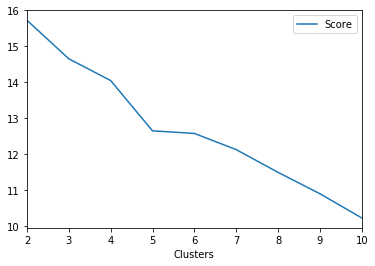

In [142]:
import matplotlib.pyplot as plt
clusterDf.plot(kind='line',x="Clusters",y="Score")
plt.show()

In [143]:
#fit for 6 clusters
kMeans = KMeans(n_clusters=6, random_state=0)
kMeans.fit(pdx_grouped_clustering)
# check cluster labels generated for each row in the dataframe
pdx_nh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [144]:
pdx_merged = df

# merge pdx_grouped with pdx_data to add latitude/longitude for each neighborhood
pdx_merged =pdx_merged.join(pdx_nh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

pdx_merged.dropna(inplace=True)

pdx_merged # check the last columns!

Neighborhood Latitude Longitude  Cluster Labels  \
0                Alameda  45.5486  -122.636             1.0   
1            Arbor Lodge  45.5718   -122.69             1.0   
2              Ardenwald  45.4642  -122.638             1.0   
3                  Argay  45.5528  -122.523             0.0   
4      Arlington Heights  45.5195  -122.711             1.0   
5           Arnold Creek  45.4443  -122.713             1.0   
6              Ash Creek  45.4613  -122.742             1.0   
7      Beaumont Wilshire  45.5504  -122.624             1.0   
8                  Boise  45.5502  -122.672             1.0   
9   Brentwood Darlington  45.4687  -122.598             1.0   
10             Bridgeton  45.6024  -122.668             1.0   
11            Bridlemile  45.4926  -122.727             2.0   
12              Brooklyn  45.4948  -122.652             1.0   
13               Buckman  45.5174  -122.652             1.0   
14            Centennial  45.5056    -122.5             1.0   
15                Center  45.5202  -122.674             1.0   
16          Collins View   45.458  -122.681             7.0   
17             Concordia  45.5659  -122.632             1.0   
19    Creston Kenilworth  45.4937  -122.623             1.0   
20             Crestwood  45.4508  -122.737             5.0   
21                 Cully  45.5615  -122.602             1.0   
22     Downtown Portland  45.5153   -122.68             1.0   
23         East Columbia  45.5938  -122.664             1.0   
24          Eastmoreland  45.4736  -122.631             2.0   
25                 Eliot  45.5412  -122.668             1.0   
26         Far Southwest  45.4399  -122.736             4.0   
27           Forest Park  45.5358  -122.739             3.0   
28         Foster Powell  45.4932  -122.589             1.0   
29        Cathedral Park  45.5876  -122.759             1.0   
30              Glenfair  45.5227  -122.504             2.0   
31          Goose Hollow  45.5177  -122.693             1.0   
32            Grant Park  45.5401  -122.628             2.0   
33         Hayden Island  45.6111  -122.679             1.0   
34              Hayhurst  45.4815  -122.729             2.0   
35             Hazelwood  45.5239  -122.538             1.0   
36         Healy Heights  45.4925  -122.699             6.0   
37             Hillsdale  45.4786  -122.695             1.0   
38              Hillside  45.5274  -122.713             6.0   
39             Hollywood  45.5359   -122.62             1.0   
40             Homestead   45.496  -122.687             1.0   
41     Hosford Abernethy  45.5066  -122.649             1.0   
42              Humboldt  45.5605  -122.671             1.0   
43             Irvington   45.542  -122.649             1.0   
44                Kenton  45.5831  -122.693             1.0   
45                 Kerns  45.5268  -122.645             1.0   
46                  King  45.5578  -122.658             1.0   
47           Laurelhurst  45.5265  -122.624             1.0   
48                 Lents  45.4797  -122.565             1.0   
49               Linnton  45.6003  -122.787             1.0   
50        Lloyd District  45.5314   -122.66             1.0   
51         Madison South   45.541  -122.573             1.0   
52             Maplewood  45.4719  -122.734             1.0   
53               Markham  45.4584  -122.704             1.0   
54         Marshall Park  45.4535  -122.696             8.0   
55             Mill Park  45.5116  -122.539             1.0   
56            Montavilla  45.5191  -122.576             1.0   
57       Mt Scott Arleta  45.4814  -122.591             1.0   
58              Mt Tabor  45.5158    -122.6             1.0   
59             Multnomah  45.4662  -122.713             1.0   
60             Northwest  45.5052  -122.611             1.0   
61     Northwest Heights  45.5408  -122.774             1.0   
63    Old Town Chinatown  45.5249  -122.674             1.0   
64              Overlook  45.5591  -122.692

In [145]:
address = 'Portland, OR'

geolocator = Nominatim(user_agent="pdx_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Portland are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Portland are 45.5202471, -122.6741949.


In [146]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pdx_merged['Latitude'], pdx_merged['Longitude'], pdx_merged['Neighborhood'], pdx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1 

In [147]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 0,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3        Argay             0.0       Thai Restaurant     Convenience Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3    Mexican Restaurant            Eye Doctor     Electronics Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3     Elementary School  Ethiopian Restaurant         Event Service   

  9th Most Common Venue 10th Most Common Venue  
3           Event Space                   Farm

#### Cluster 2

In [148]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 1,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
0                Alameda             1.0         Garden Center   
1            Arbor Lodge             1.0     Convenience Store   
2              Ardenwald             1.0  Marijuana Dispensary   
4      Arlington Heights             1.0                Garden   
5           Arnold Creek             1.0            Restaurant   
6              Ash Creek             1.0                  Park   
7      Beaumont Wilshire             1.0           Pizza Place   
8                  Boise             1.0           Pizza Place   
9   Brentwood Darlington             1.0                  Park   
10             Bridgeton             1.0       Harbor / Marina   
12              Brooklyn             1.0                   Bar   
13               Buckman             1.0           Coffee Shop   
14            Centennial             1.0                   ATM   
15                Center             1.0                 Hotel   
17             Concordia             1.0           Coffee Shop   
19    Creston Kenilworth             1.0           Coffee Shop   
21                 Cully             1.0            Taco Place   
22     Downtown Portland             1.0           Coffee Shop   
23         East Columbia             1.0                Casino   
25                 Eliot             1.0                  Park   
28         Foster Powell             1.0           Flower Shop   
29        Cathedral Park             1.0           Coffee Shop   
31          Goose Hollow             1.0           Pizza Place   
33         Hayden Island             1.0                 Hotel   
35             Hazelwood             1.0              Pharmacy   
37             Hillsdale             1.0           Pizza Place   
39             Hollywood             1.0           Coffee Shop   
40             Homestead             1.0            Restaurant   
41     Hosford Abernethy             1.0                   Bar   
42              Humboldt             1.0                   Bar   
43             Irvington             1.0           Yoga Studio   
44                Kenton             1.0           Coffee Shop   
45                 Kerns             1.0                   Bar   
46                  King             1.0              Bus Stop   
47           Laurelhurst             1.0              Bus Stop   
48                 Lents             1.0    Mexican Restaurant   
49               Linnton             1.0     Convenience Store   
50        Lloyd District             1.0           Coffee Shop   
51         Madison South             1.0                   Pub   
52             Maplewood             1.0                  Park   
53               Markham             1.0    Mexican Restaurant   
55             Mill Park             1.0           Pizza Place   
56            Montavilla             1.0              Bus Stop   
57       Mt Scott Arleta             1.0                  Park   
58              Mt Tabor             1.0           Cheese Shop   
59             Multnomah             1.0           Coffee Shop   
60             Northwest             1.0            Food Truck   
61     Northwest Heights             1.0                  Park   
63    Old Town Chinatown             1.0                 Hotel   
64              Overlook             1.0   Sporting Goods Shop   
65      Parkrose Heights             1.0                  Park   
66              Parkrose             1.0    Mexican Restaurant   
67        Pearl District             1.0           Coffee Shop   
68              Piedmont             1.0    Mexican Restaurant   
70            Portsmouth             1.0                  Park   
71   Powellhurst Gilbert             1.0     Convenience Store   
72                  Reed             1.0     Convenience Store   
73              Richmond             1.0              Tea Room   
74        Rose City Park             1.0            Food Truck   
75               Roseway             1.0            

#### Cluster 3 

In [149]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 2,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
11       Bridlemile             2.0                  Park   
24     Eastmoreland             2.0                  Park   
30         Glenfair             2.0                  Park   
32       Grant Park             2.0                  Park   
34         Hayhurst             2.0      Recording Studio   
69  Pleasant Valley             2.0                  Park   
76          Russell             2.0                  Food   

   2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
11          Tennis Court           Event Space  Eastern European Restaurant   
24           Zoo Exhibit           Flower Shop                  Flea Market   
30           Zoo Exhibit           Flower Shop                  Flea Market   
32           Zoo Exhibit           Flower Shop                  Flea Market   
34                  Park           Zoo Exhibit                Event Service   
69         Event Service           Zoo Exhibit                  Flower Shop   
76                  Park           Event Space                    Drugstore   

          5th Most Common Venue        6th Most Common Venue  \
11            Electronics Store            Elementary School   
24                  Fish Market         Fast Food Restaurant   
30                  Fish Market         Fast Food Restaurant   
32                  Fish Market         Fast Food Restaurant   
34                    Drugstore  Eastern European Restaurant   
69                  Flea Market                  Fish Market   
76  Eastern European Restaurant            Electronics Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
11  Ethiopian Restaurant         Event Service           Zoo Exhibit   
24        Farmers Market                  Farm            Eye Doctor   
30        Farmers Market                  Farm            Eye Doctor   
32        Farmers Market                  Farm            Eye Doctor   
34     Electronics Store     Elementary School  Ethiopian Restaurant   
69  Fast Food Restaurant        Farmers Market                  Farm   
76     Elementary School  Ethiopian Restaurant         Event Service   

   10th Most Common Venue  
11              Drugstore  
24            Event Space  
30            Event Space  
32            Event Space  
34             Eye Doctor  
69             Eye Doctor  
76            Zoo Exhibit

#### Cluster 4 

In [150]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 3,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
27  Forest Park             3.0                 Trail           Zoo Exhibit   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
27            Eye Doctor     Electronics Store     Elementary School   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
27  Ethiopian Restaurant         Event Service           Event Space   

   9th Most Common Venue 10th Most Common Venue  
27                  Farm              Drugstore

#### Cluster 5

In [151]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 4,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
26  Far Southwest             4.0     College Cafeteria           Zoo Exhibit   

   3rd Most Common Venue        4th Most Common Venue 5th Most Common Venue  \
26            Eye Doctor  Eastern European Restaurant     Electronics Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
26     Elementary School  Ethiopian Restaurant         Event Service   

   9th Most Common Venue 10th Most Common Venue  
26           Event Space                   Farm

#### Cluster 6

In [152]:
pdx_merged.loc[pdx_merged['Cluster Labels'] == 5,pdx_merged.columns[[0] + list(range(3,pdx_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
20    Crestwood             5.0          Home Service            Playground   

   3rd Most Common Venue 4th Most Common Venue        5th Most Common Venue  \
20           Zoo Exhibit            Eye Doctor  Eastern European Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
20     Electronics Store     Elementary School  Ethiopian Restaurant   

   9th Most Common Venue 10th Most Common Venue  
20         Event Service            Event Space

## MILWAUKEE

#### Get neighborhoods from Wikipedia page scrape

In [153]:
!wget -q -O 'mke_nbh.html' https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Milwaukee
print('Download finished')

Download finished


#### Scrape the page by css class and assign to dataframe

In [154]:
OPENMAP_GCAPI = 'http://open.mapquestapi.com/geocoding/v1/address?key='+OPENMAPKEY+'&location={0},Milwaukee, WI'
with open("mke_nbh.html") as mkeHtml:
    soup = BeautifulSoup(mkeHtml)
    spans = soup.find_all("span", class_="mw-headline")
    row_count = len(spans)
    
    df = pd.DataFrame(columns=["Neighborhood","Latitude","Longitude"],index=range(0,row_count))
    
    row_marker = 0
    for span in spans:
        spanText = span.get_text()
        df.iat[row_marker,0] = spanText
        response = requests.get(OPENMAP_GCAPI.format(spanText)) #geocoder call
        if response.status_code == 200:
            jsonResp = json.loads(response.content.decode('utf-8'))
            lat = jsonResp['results'][0]['locations'][0]['latLng']['lat']
            long = jsonResp['results'][0]['locations'][0]['latLng']['lng']
            print('Hood: ', spanText, 'Lat: ', lat, ' Long: ', long)
            df.iat[row_marker,1] = lat
            df.iat[row_marker,2] = long
        row_marker +=1
            
df

Hood:  Milwaukee's North Side Lat:  39.78373  Long:  -100.445882
Hood:  Arlington Heights Lat:  43.085435  Long:  -87.929136
Hood:  Brewers' Hill Lat:  43.05635  Long:  -87.909795
Hood:  Franklin Heights Lat:  43.08258  Long:  -87.94526
Hood:  Granville Lat:  43.177508  Long:  -88.043978
Hood:  Grover Heights Lat:  43.093766  Long:  -87.921691
Hood:  Halyard Park Lat:  43.056461  Long:  -87.916381
Hood:  Harambee Lat:  43.071275  Long:  -87.912977
Hood:  Bronzeville Lat:  43.066305  Long:  -87.916588
Hood:  Havenwoods Lat:  43.125804  Long:  -87.976368
Hood:  Hillside / Lapham Park Lat:  43.049309  Long:  -87.920887
Hood:  Metcalfe Park Lat:  43.064266  Long:  -87.954256
Hood:  Midtown Lat:  43.052507  Long:  -87.944781
Hood:  Park West Lat:  43.067862  Long:  -87.942446
Hood:  Sherman Park Lat:  43.073236  Long:  -87.960071
Hood:  Thurston Woods Lat:  43.123596  Long:  -87.956268
Hood:  Williamsburg Heights Lat:  43.085342  Long:  -87.913007
Hood:  Milwaukee's South Side Lat:  39.7837

Neighborhood Latitude Longitude
0        Milwaukee's North Side  39.7837  -100.446
1             Arlington Heights  43.0854  -87.9291
2                 Brewers' Hill  43.0564  -87.9098
3              Franklin Heights  43.0826  -87.9453
4                     Granville  43.1775   -88.044
5                Grover Heights  43.0938  -87.9217
6                  Halyard Park  43.0565  -87.9164
7                      Harambee  43.0713   -87.913
8                   Bronzeville  43.0663  -87.9166
9                    Havenwoods  43.1258  -87.9764
10       Hillside / Lapham Park  43.0493  -87.9209
11                Metcalfe Park  43.0643  -87.9543
12                      Midtown  43.0525  -87.9448
13                    Park West  43.0679  -87.9424
14                 Sherman Park  43.0732  -87.9601
15               Thurston Woods  43.1236  -87.9563
16         Williamsburg Heights  43.0853   -87.913
17       Milwaukee's South Side  39.7837  -100.446
18                     Bay View  42.9975  -87.8972
19                Clarke Square  43.0208  -87.9404
20                  Holler Park  42.9487  -87.9166
21                 Jackson Park  42.9941  -87.9679
22                 Jones Island  43.0152  -87.8978
23                  Layton Park  43.0013  -87.9527
24              Lincoln Village   43.002  -87.9248
25              Mitchell Street  39.7837  -100.446
26                   Tippecanoe  42.9762  -87.8953
27                 Town of Lake  42.9644  -87.9068
28               Walker's Point  43.0238  -87.9221
29        Milwaukee's East Side  39.7837  -100.446
30              "The East Side"  43.0629  -87.8819
31              Lower East Side  43.0536  -87.8897
32                 East Village  43.0551  -87.9006
33                  Murray Hill  43.0655   -87.883
34                    Riverwest  43.0723  -87.8991
35                   Beerline B  43.0544  -87.9067
36        Milwaukee's West Side  39.7837  -100.446
37                 Avenues West  43.0394  -87.9363
38              University Hill  43.0389  -87.9322
39             Cold Spring Park  43.0469  -87.9527
40  Historic Concordia District  39.7837  -100.446
41                 Enderis Park  43.0712  -87.9974
42                    Kops Park    43.08  -88.0207
43             Grantosa Heights   43.114  -87.9996
44                 Martin Drive   43.047  -87.9889
45                 Merrill Park  43.0358  -87.9553
46                   Piggsville  39.7837  -100.446
47                   Mount Mary  43.0731  -88.0296
48                   Story Hill  43.0339  -87.9763
49                  Walnut Hill  43.0545  -87.9539
50           Washington Heights  43.0548  -87.9797
51              Washington Park  43.0547  -87.9647
52         Milwaukee's Downtown  39.7837  -100.446
53                    East Town  43.0419  -87.9038
54       Menomonee River Valley  43.0298  -87.9425
55          Historic Third Ward  43.0312  -87.9016
56                      Westown  43.0415  -87.9191
57                     See also  39.7837  -100.446
58                   References  39.7837  -100.446
59               External links  39.7837  -100.446

In [155]:
# Get names of indexes for which column contains string "Milwaukee's" or latitude is less than 42 (error in neighborhood lookup)
indexNames = df[df['Neighborhood'].str.contains("Milwaukee's")].index
indexNames = indexNames.union(df[df["Latitude"] < float(42)].index)
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
# Drop last 3 rows as well
df.drop(df.tail(3).index,inplace=True) 
df.reset_index()
df

Neighborhood Latitude Longitude
1        Arlington Heights  43.0854  -87.9291
2            Brewers' Hill  43.0564  -87.9098
3         Franklin Heights  43.0826  -87.9453
4                Granville  43.1775   -88.044
5           Grover Heights  43.0938  -87.9217
6             Halyard Park  43.0565  -87.9164
7                 Harambee  43.0713   -87.913
8              Bronzeville  43.0663  -87.9166
9               Havenwoods  43.1258  -87.9764
10  Hillside / Lapham Park  43.0493  -87.9209
11           Metcalfe Park  43.0643  -87.9543
12                 Midtown  43.0525  -87.9448
13               Park West  43.0679  -87.9424
14            Sherman Park  43.0732  -87.9601
15          Thurston Woods  43.1236  -87.9563
16    Williamsburg Heights  43.0853   -87.913
18                Bay View  42.9975  -87.8972
19           Clarke Square  43.0208  -87.9404
20             Holler Park  42.9487  -87.9166
21            Jackson Park  42.9941  -87.9679
22            Jones Island  43.0152  -87.8978
23             Layton Park  43.0013  -87.9527
24         Lincoln Village   43.002  -87.9248
26              Tippecanoe  42.9762  -87.8953
27            Town of Lake  42.9644  -87.9068
28          Walker's Point  43.0238  -87.9221
30         "The East Side"  43.0629  -87.8819
31         Lower East Side  43.0536  -87.8897
32            East Village  43.0551  -87.9006
33             Murray Hill  43.0655   -87.883
34               Riverwest  43.0723  -87.8991
35              Beerline B  43.0544  -87.9067
37            Avenues West  43.0394  -87.9363
38         University Hill  43.0389  -87.9322
39        Cold Spring Park  43.0469  -87.9527
41            Enderis Park  43.0712  -87.9974
42               Kops Park    43.08  -88.0207
43        Grantosa Heights   43.114  -87.9996
44            Martin Drive   43.047  -87.9889
45            Merrill Park  43.0358  -87.9553
47              Mount Mary  43.0731  -88.0296
48              Story Hill  43.0339  -87.9763
49             Walnut Hill  43.0545  -87.9539
50      Washington Heights  43.0548  -87.9797
51         Washington Park  43.0547  -87.9647
53               East Town  43.0419  -87.9038

In [164]:
mke_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Arlington Heights
{'meta': {'code': 200, 'requestId': '5dbdb945a30619002c745a90'}, 'response': {'headerLocation': 'Milwaukee', 'headerFullLocation': 'Milwaukee', 'headerLocationGranularity': 'city', 'totalResults': 4, 'suggestedBounds': {'ne': {'lat': 43.0899350045, 'lng': -87.9229859501491}, 'sw': {'lat': 43.080934995499994, 'lng': -87.9352860498509}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4f0346f1722e0f07753f6531', 'name': "Navy's Cafe", 'location': {'address': 'W Atkinson Ave', 'crossStreet': 'btw N 13th St and N 14th St', 'lat': 43.08561249010613, 'lng': -87.92798643591911, 'labeledLatLngs': [{'label': 'display', 'lat': 43.08561249010613, 'lng': -87.92798643591911}], 'distance': 95, 'postalCode': '53206', 'cc': 'US', 'city': 'Milwaukee', 'state': 'WI', 'country': 'United States', 'formattedAddress

KeyError: 'groups'

In [165]:
# one hot encoding
mke_onehot = pd.get_dummies(mke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mke_onehot['Neighborhood'] = mke_venues['Neighborhood'] 

# move neighborhood column to the first column
nbh = mke_onehot['Neighborhood']
mke_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
mke_onehot.insert(0, 'Neighborhood', nbh)

mke_onehot.head()

Neighborhood  African Restaurant  Airport Terminal  \
0  Arlington Heights                   0                 0   
1  Arlington Heights                   0                 0   
2  Arlington Heights                   0                 0   
3  Arlington Heights                   0                 0   
4      Brewers' Hill                   0                 0   

   American Restaurant  Antique Shop  Arcade  Art Gallery  Art Museum  \
0                    0             0       0            0           0   
1                    0             0       0            0           0   
2                    0             0       0            0           0   
3                    0             0       0            0           0   
4                    0             0       0            0           0   

   Asian Restaurant  Athletics & Sports  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                 0                   0          0           0       0     0   
1                 0                   0          0           0       0     0   
2                 0                   0          0           0       0     0   
3                 0                   0          0           0       0     0   
4                 0                   0          0           0       0     0   

   Bar  Baseball Field  Baseball Stadium  Basketball Court  Bed & Breakfast  \
0    0               0                 0                 0                0   
1    1               0                 0                 0                0   
2    0               0                 0                 0                0   
3    0               0                 0                 0                0   
4    0               0                 0                 0                0   

   Beer Bar  Beer Garden  Bookstore  Boutique  Bowling Alley  Breakfast Spot  \
0         0            0          0         0              0               0   
1         0            0          0         0              0               0   
2         0            0          0         0              0               0   
3         0            0          0         0              0               0   
4         0            0          0         0              0               1   

   Brewery  Burger Joint  Burrito Place  Bus Station  Bus Stop  \
0        0             0              0            0         0   
1        0             0              0            0         0   
2        0             0              0            0         0   
3        0             0              0            0         0   
4        0             0              0            0         0   

   Business Service  Butcher  Café  Candy Store  Chinese Restaurant  \
0                 0        0     0            0                   0   
1                 0        0     0            0                   0   
2                 0        0     0            0                   0   
3                 0        0     0            0                   0   
4                 0        0     0            0                   0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Basketball Court  \
0               0             0            0                         0   
1               0             0            0                         0   
2               0             0            0                         0   
3               0             0            0                         0   
4               0             0            0                         0   

   College Rec Center  College Residence Hall  Construction & Landscaping  \
0                   0                       0                           0   
1                   0                       0                           0   
2                   0                       0                           0   
3                   0                       0                           0   
4                   0                       0                           0   

   Convenience Store  Cosme

In [166]:
mke_grouped = mke_onehot.groupby('Neighborhood').mean().reset_index()
mke_grouped

Neighborhood  African Restaurant  Airport Terminal  \
0          "The East Side"            0.000000               0.0   
1        Arlington Heights            0.000000               0.0   
2             Avenues West            0.000000               0.0   
3                 Bay View            0.000000               0.0   
4               Beerline B            0.000000               0.0   
5            Brewers' Hill            0.000000               0.0   
6              Bronzeville            0.000000               0.0   
7            Clarke Square            0.000000               0.0   
8         Cold Spring Park            0.000000               0.0   
9                East Town            0.000000               0.0   
10            East Village            0.000000               0.0   
11            Enderis Park            0.000000               0.0   
12        Franklin Heights            0.000000               0.0   
13        Grantosa Heights            0.000000               0.0   
14               Granville            0.000000               0.0   
15          Grover Heights            0.000000               0.0   
16            Halyard Park            0.000000               0.0   
17                Harambee            0.000000               0.0   
18              Havenwoods            0.000000               0.0   
19  Hillside / Lapham Park            0.000000               0.0   
20             Holler Park            0.000000               0.1   
21            Jackson Park            0.000000               0.0   
22            Jones Island            0.000000               0.0   
23               Kops Park            0.000000               0.0   
24             Layton Park            0.000000               0.0   
25         Lincoln Village            0.000000               0.0   
26         Lower East Side            0.017857               0.0   
27            Martin Drive            0.000000               0.0   
28            Merrill Park            0.000000               0.0   
29           Metcalfe Park            0.000000               0.0   
30                 Midtown            0.000000               0.0   
31              Mount Mary            0.000000               0.0   
32             Murray Hill            0.000000               0.0   
33               Park West            0.000000               0.0   
34               Riverwest            0.000000               0.0   
35            Sherman Park            0.000000               0.0   
36              Story Hill            0.000000               0.0   
37          Thurston Woods            0.000000               0.0   
38              Tippecanoe            0.000000               0.0   
39            Town of Lake            0.000000               0.0   
40         University Hill            0.000000               0.0   
41          Walker's Point            0.000000               0.0   
42             Walnut Hill            0.000000               0.0   
43      Washington Heights            0.000000               0.0   
44         Washington Park            0.000000               0.0   
45    Williamsburg Heights            0.000000               0.0   

    American Restaurant  Antique Shop    Arcade  Art Gallery  Art Museum  \
0              0.000000      0.000000  0.000000     0.000000    0.000000   
1              0.000000      0.000000  0.000000     0.000000    0.000000   
2              0.073171      0.000000  0.000000     0.000000    0.000000   
3              0.026316      0.000000  0.000000     0.026316    0.000000   
4              0.027027      0.000000  0.027027     0.000000    0.000000   
5              0.000000      0.000000  0.000000     0.000000    0.000000   
6              0.000000      0.000000  0.000000     0.000000    0.000000   
7              0.000000      0.000000  0.000000     0.000000    0.000000   
8              0.000000      0.000000  0.000000     0.000000    0.000000   
9              0.020000      0.000000  0.000000     0.000

In [167]:
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mke_nh_venues_sorted = pd.DataFrame(columns=columns)
mke_nh_venues_sorted['Neighborhood'] = mke_grouped['Neighborhood']

for ind in np.arange(mke_grouped.shape[0]):
    mke_nh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mke_grouped.iloc[ind, :], num_top_venues)

mke_nh_venues_sorted.head()

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
0    "The East Side"           Pizza Place                      Pub   
1  Arlington Heights     Fish & Chips Shop                   Lounge   
2       Avenues West        Sandwich Place      American Restaurant   
3           Bay View                   Bar  New American Restaurant   
4         Beerline B                  Café                     Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Bar         Movie Theater    Mexican Restaurant   
1                   Bar      Greek Restaurant           Yoga Studio   
2     Convenience Store         Grocery Store           Coffee Shop   
3              Dive Bar           High School    Chinese Restaurant   
4                   Spa           Pizza Place                Lounge   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0        Sandwich Place           Coffee Shop            Food Court   
1            Food Truck     Food & Drink Shop                  Food   
2           Pizza Place                 Diner        Cosmetics Shop   
3          Liquor Store  Fast Food Restaurant              Bus Stop   
4           Coffee Shop    Chinese Restaurant               Brewery   

     9th Most Common Venue                    10th Most Common Venue  
0        Mobile Phone Shop                         Food & Drink Shop  
1              Flower Shop                      Fast Food Restaurant  
2           Clothing Store  Residential Building (Apartment / Condo)  
3               Restaurant                  Mediterranean Restaurant  
4  New American Restaurant                                Playground

In [168]:
mke_grouped_clustering =mke_grouped.drop('Neighborhood', 1)

kMeans = {}
pdxBestCluster=0
clusterData = []

for kclusters in range(2,11):
    # run k-means clustering
    testKMeans = KMeans(n_clusters=kclusters, random_state=0)
    score = testKMeans.fit(mke_grouped_clustering).inertia_
    print("Clusters: ", kclusters, " Score: ", score)
    clusterData.append([kclusters,score])


Clusters:  2  Score:  6.219343156493729
Clusters:  3  Score:  5.638678497648008
Clusters:  4  Score:  5.207500518866754
Clusters:  5  Score:  4.787435713773749
Clusters:  6  Score:  4.569127677513965
Clusters:  7  Score:  4.34129459706813
Clusters:  8  Score:  4.105302610258104
Clusters:  9  Score:  3.888155936510829
Clusters:  10  Score:  3.553687214085433


In [169]:
clusterData
clusterDf  = pd.DataFrame(clusterData,columns=["Clusters","Score"])

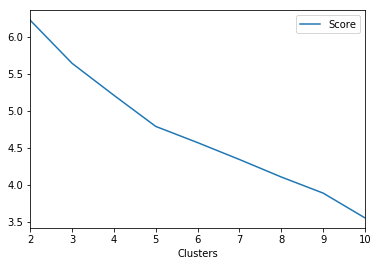

In [170]:
import matplotlib.pyplot as plt
clusterDf.plot(kind='line',x="Clusters",y="Score")
plt.show()

In [171]:
#fit for 5 clusters
mkeKMeans = KMeans(n_clusters=5, random_state=0)
mkeKMeans.fit(mke_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(len(mkeKMeans.labels_))
len(mke_nh_venues_sorted)

46


46

In [172]:
mke_nh_venues_sorted.insert(0, 'Cluster Labels', mkeKMeans.labels_)

In [173]:
mke_merged = df

# merge mke_grouped with mke_data to add latitude/longitude for each neighborhood
mke_merged =mke_merged.join(mke_nh_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mke_merged.dropna(inplace=True)

mke_merged # check the last columns!

Neighborhood Latitude Longitude  Cluster Labels  \
1        Arlington Heights  43.0854  -87.9291               1   
2            Brewers' Hill  43.0564  -87.9098               0   
3         Franklin Heights  43.0826  -87.9453               0   
4                Granville  43.1775   -88.044               1   
5           Grover Heights  43.0938  -87.9217               0   
6             Halyard Park  43.0565  -87.9164               0   
7                 Harambee  43.0713   -87.913               1   
8              Bronzeville  43.0663  -87.9166               0   
9               Havenwoods  43.1258  -87.9764               4   
10  Hillside / Lapham Park  43.0493  -87.9209               0   
11           Metcalfe Park  43.0643  -87.9543               0   
12                 Midtown  43.0525  -87.9448               0   
13               Park West  43.0679  -87.9424               0   
14            Sherman Park  43.0732  -87.9601               0   
15          Thurston Woods  43.1236  -87.9563               1   
16    Williamsburg Heights  43.0853   -87.913               0   
18                Bay View  42.9975  -87.8972               0   
19           Clarke Square  43.0208  -87.9404               0   
20             Holler Park  42.9487  -87.9166               0   
21            Jackson Park  42.9941  -87.9679               3   
22            Jones Island  43.0152  -87.8978               3   
23             Layton Park  43.0013  -87.9527               1   
24         Lincoln Village   43.002  -87.9248               0   
26              Tippecanoe  42.9762  -87.8953               0   
27            Town of Lake  42.9644  -87.9068               1   
28          Walker's Point  43.0238  -87.9221               0   
30         "The East Side"  43.0629  -87.8819               0   
31         Lower East Side  43.0536  -87.8897               0   
32            East Village  43.0551  -87.9006               1   
33             Murray Hill  43.0655   -87.883               0   
34               Riverwest  43.0723  -87.8991               1   
35              Beerline B  43.0544  -87.9067               0   
37            Avenues West  43.0394  -87.9363               0   
38         University Hill  43.0389  -87.9322               0   
39        Cold Spring Park  43.0469  -87.9527               2   
41            Enderis Park  43.0712  -87.9974               3   
42               Kops Park    43.08  -88.0207               0   
43        Grantosa Heights   43.114  -87.9996               1   
44            Martin Drive   43.047  -87.9889               0   
45            Merrill Park  43.0358  -87.9553               0   
47              Mount Mary  43.0731  -88.0296               0   
48              Story Hill  43.0339  -87.9763               1   
49             Walnut Hill  43.0545  -87.9539               0   
50      Washington Heights  43.0548  -87.9797               0   
51         Washington Park  43.0547  -87.9647               3   
53               East Town  43.0419  -87.9038               0   

   1st Most Common Venue    2nd Most Common Venue 3rd Most Common Venue  \
1      Fish & Chips Shop                   Lounge                   Bar   
2         Breakfast Spot           Lingerie Store           Pizza Place   
3                  Hotel           Clothing Store          Liquor Store   
4                    Pub                      Bar    Mexican Restaurant   
5      Convenience Store              Flower Shop           Music Store   
6             Shoe Store           Cosmetics Shop  Fast Food Restaurant   
7               Pharmacy                      Bar           Video Store   
8    Fried Chicken Joint                     Bank                Lounge   
9      Recreation Center              Yoga Studio   Dumpling Restaurant   
10               Brewery                    Hotel                  Park   
11         Grocery Store              Video Store        Sandwich Place   
12     Convenience Store                     Food   Americ

In [174]:
address = 'Milwaukee, WI'

geolocator = Nominatim(user_agent="mke_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Milwaukee are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Milwaukee are 43.0349931, -87.922497.


In [175]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mke_merged['Latitude'], mke_merged['Longitude'], mke_merged['Neighborhood'], mke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [176]:
mke_merged.loc[mke_merged['Cluster Labels'] == 0,mke_merged.columns[[0] + list(range(3,mke_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
2            Brewers' Hill               0        Breakfast Spot   
3         Franklin Heights               0                 Hotel   
5           Grover Heights               0     Convenience Store   
6             Halyard Park               0            Shoe Store   
8              Bronzeville               0   Fried Chicken Joint   
10  Hillside / Lapham Park               0               Brewery   
11           Metcalfe Park               0         Grocery Store   
12                 Midtown               0     Convenience Store   
13               Park West               0     Convenience Store   
14            Sherman Park               0   Fried Chicken Joint   
16    Williamsburg Heights               0              Wine Bar   
18                Bay View               0                   Bar   
19           Clarke Square               0    Mexican Restaurant   
20             Holler Park               0                 Hotel   
24         Lincoln Village               0    Mexican Restaurant   
26              Tippecanoe               0    Mexican Restaurant   
28          Walker's Point               0    Mexican Restaurant   
30         "The East Side"               0           Pizza Place   
31         Lower East Side               0                   Bar   
33             Murray Hill               0     Food & Drink Shop   
35              Beerline B               0                  Café   
37            Avenues West               0        Sandwich Place   
38         University Hill               0        Sandwich Place   
42               Kops Park               0           Pizza Place   
44            Martin Drive               0  Gym / Fitness Center   
45            Merrill Park               0                   Bar   
47              Mount Mary               0              Pharmacy   
49             Walnut Hill               0                Bakery   
50      Washington Heights               0                Garden   
53               East Town               0                 Hotel   

      2nd Most Common Venue 3rd Most Common Venue   4th Most Common Venue  \
2            Lingerie Store           Pizza Place             Coffee Shop   
3            Clothing Store          Liquor Store           Grocery Store   
5               Flower Shop           Music Store    Fast Food Restaurant   
6            Cosmetics Shop  Fast Food Restaurant                 Brewery   
8                      Bank                Lounge                    Café   
10                    Hotel                  Park        Business Service   
11              Video Store        Sandwich Place             Yoga Studio   
12                     Food   American Restaurant                    Park   
13             Burger Joint        History Museum          Sandwich Place   
14     Fast Food Restaurant         Grocery Store       Recreation Center   
16                     Bank         Historic Site  Thrift / Vintage Store   
18  New American Restaurant              Dive Bar             High School   
19               Laundromat           Pizza Place      Athletics & Sports   
20                    Trail                 Motel          Clothing Store   
24              Pizza Place         Deli / Bodega                  Bakery   
26                      Bar                  Park       Convenience Store   
28                Nightclub          Cocktail Bar      Spanish Restaurant   
30                      Pub                   Bar           Movie Theater   
31              Yoga Studio       Thai Restaurant      Salon / Barbershop   
33              Coffee Shop             Bookstore                Pharmacy   
35                     Park                   Spa             Pizza Place   
37      American Restaurant     Convenience Store           Grocery Store   
38              Coffee Shop                 Diner       Convenience Store   
42       Chinese Restaurant                  Park      Me

## Cluster 2

In [177]:
mke_merged.loc[mke_merged['Cluster Labels'] == 1,mke_merged.columns[[0] + list(range(3,mke_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
1   Arlington Heights               1     Fish & Chips Shop   
4           Granville               1                   Pub   
7            Harambee               1              Pharmacy   
15     Thurston Woods               1   Fried Chicken Joint   
23        Layton Park               1    Mexican Restaurant   
27       Town of Lake               1                   Bar   
32       East Village               1                   Bar   
34          Riverwest               1                   Bar   
43   Grantosa Heights               1                   Bar   
48         Story Hill               1                  Park   

   2nd Most Common Venue 3rd Most Common Venue       4th Most Common Venue  \
1                 Lounge                   Bar            Greek Restaurant   
4                    Bar    Mexican Restaurant  Construction & Landscaping   
7                    Bar           Video Store                        Café   
15          Liquor Store        Cosmetics Shop           Convenience Store   
23                   Bar                Bakery                Intersection   
27   American Restaurant           Pop-Up Shop              Massage Studio   
32    Chinese Restaurant               Brewery          Mexican Restaurant   
34        Baseball Field         Grocery Store          Mexican Restaurant   
43   Fried Chicken Joint         Grocery Store                  Food Truck   
48            Sports Bar                   Bar            Baseball Stadium   

   5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
1            Yoga Studio                 Food Truck     Food & Drink Shop   
4       Asian Restaurant             Sandwich Place        Rental Service   
7                 Lounge              Grocery Store        Baseball Field   
15                  Food                        Bar     Food & Drink Shop   
23     Food & Drink Shop          Electronics Store          Burger Joint   
27              Dive Bar                Yoga Studio     Food & Drink Shop   
32                  Park  Middle Eastern Restaurant                School   
34               Brewery             Farmers Market         Deli / Bodega   
43            Food Court          Food & Drink Shop                  Food   
48           Pizza Place        American Restaurant         Historic Site   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
1                     Food           Flower Shop   Fast Food Restaurant  
4             Liquor Store           Yoga Studio    Empanada Restaurant  
7                     Bank                  Food            Flower Shop  
15             Flower Shop     Fish & Chips Shop   Fast Food Restaurant  
23            Liquor Store                 River                  Diner  
27                    Food           Flower Shop      Fish & Chips Shop  
32              Playground           Pizza Place            Coffee Shop  
34  Furniture / Home Store                   Spa              Gastropub  
43             Flower Shop     Fish & Chips Shop   Fast Food Restaurant  
48            Intersection  Ethiopian Restaurant      Electronics Store

## Cluster 3

In [178]:
mke_merged.loc[mke_merged['Cluster Labels'] == 2,mke_merged.columns[[0] + list(range(3,mke_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
39  Cold Spring Park               2        Cosmetics Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
39    Seafood Restaurant        Discount Store     Electronics Store   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
39                  Food           Flower Shop     Fish & Chips Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
39  Fast Food Restaurant        Farmers Market   Ethiopian Restaurant

## Cluster 4

In [179]:
mke_merged.loc[mke_merged['Cluster Labels'] == 3,mke_merged.columns[[0] + list(range(3,mke_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
21     Jackson Park               3            Playground   
22     Jones Island               3                  Park   
41     Enderis Park               3                  Park   
51  Washington Park               3                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
21                  Park                  Pool        History Museum   
22       Harbor / Marina           Yoga Studio   Dumpling Restaurant   
41            Playground        Farmers Market   Sporting Goods Shop   
51  Other Great Outdoors                   Bar           Yoga Studio   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
21              Dive Bar     Fish & Chips Shop  Fast Food Restaurant   
22                  Food           Flower Shop     Fish & Chips Shop   
41                Office         Grocery Store    Salon / Barbershop   
51   Empanada Restaurant     Food & Drink Shop                  Food   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
21        Farmers Market  Ethiopian Restaurant    Empanada Restaurant  
22  Fast Food Restaurant        Farmers Market   Ethiopian Restaurant  
41   Dumpling Restaurant     Fish & Chips Shop   Fast Food Restaurant  
51           Flower Shop     Fish & Chips Shop   Fast Food Restaurant

## Cluster 5

In [180]:
mke_merged.loc[mke_merged['Cluster Labels'] == 4,mke_merged.columns[[0] + list(range(3,mke_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
9   Havenwoods               4     Recreation Center           Yoga Studio   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
9   Dumpling Restaurant                  Food           Flower Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
9     Fish & Chips Shop  Fast Food Restaurant        Farmers Market   

  9th Most Common Venue 10th Most Common Venue  
9  Ethiopian Restaurant    Empanada Restaurant

## Comparision

In [187]:
#Let's make a new data set with all neighborhoods in it and run it through clustering to see what we get
allNH_grouped_clustering = mke_grouped_clustering.append(pdx_grouped_clustering)

In [201]:

allNH_grouped_clustering.fillna(0,inplace=True)
#allNH_grouped_clustering=allNH_grouped_clustering.drop("City",axis=1)
allNH_grouped_clustering.head()

ATM  Accessories Store  Adult Boutique  African Restaurant  \
0  0.0                0.0             0.0                 0.0   
1  0.0                0.0             0.0                 0.0   
2  0.0                0.0             0.0                 0.0   
3  0.0                0.0             0.0                 0.0   
4  0.0                0.0             0.0                 0.0   

   Airport Terminal  American Restaurant  Amphitheater  Antique Shop  \
0               0.0             0.000000           0.0           0.0   
1               0.0             0.000000           0.0           0.0   
2               0.0             0.073171           0.0           0.0   
3               0.0             0.026316           0.0           0.0   
4               0.0             0.027027           0.0           0.0   

     Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0  0.000000     0.000000         0.0                  0.0   
1  0.000000     0.000000         0.0                  0.0   
2  0.000000     0.000000         0.0                  0.0   
3  0.000000     0.026316         0.0                  0.0   
4  0.027027     0.000000         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0          0.029412            0.000000   
1                   0.0          0.000000            0.000000   
2                   0.0          0.000000            0.000000   
3                   0.0          0.000000            0.000000   
4                   0.0          0.000000            0.027027   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0              0.0          0.0            0.0              0.0    0.00000   
1              0.0          0.0            0.0              0.0    0.00000   
2              0.0          0.0            0.0              0.0    0.02439   
3              0.0          0.0            0.0              0.0    0.00000   
4              0.0          0.0            0.0              0.0    0.00000   

   Bagel Shop    Bakery      Bank       Bar  Baseball Field  Baseball Stadium  \
0     0.00000  0.029412  0.029412  0.058824             0.0               0.0   
1     0.00000  0.000000  0.000000  0.250000             0.0               0.0   
2     0.02439  0.000000  0.024390  0.024390             0.0               0.0   
3     0.00000  0.000000  0.026316  0.078947             0.0               0.0   
4     0.00000  0.000000  0.000000  0.000000             0.0               0.0   

   Basketball Court  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0               0.0              0.0  0.029412          0.0         0.0   
1               0.0              0.0  0.000000          0.0         0.0   
2               0.0              0.0  0.000000          0.0         0.0   
3               0.0              0.0  0.000000          0.0         0.0   
4               0.0              0.0  0.000000          0.0         0.0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Board Shop  Bookstore  \
0            0.0                       0.0        0.0         0.0   0.029412   
1            0.0                       0.0        0.0         0.0   0.000000   
2            0.0                       0.0        0.0         0.0   0.000000   
3            0.0                       0.0        0.0         0.0   0.000000   
4            0.0                       0.0        0.0         0.0   0.000000   

   Botanical Garden  Boutique  Bowling Alley  Brazilian Restaurant  \
0               0.0  0.029412       0.029412                   0.0   
1               0.0  0.000000       0.000000                   0.0   
2               0.0  0.000000       0.024390                   0.0   
3               0.0  0.000000       0.000000                   0.0   
4               0.0  0.000000       0.000000                   0.0   

   Breakfast Spot   Brewery  Bubble Tea Shop  Building  Burger Joint  \
0        0.000000  0.000000             

In [202]:
kMeans = {}
BestCluster=0
clusterData = []

for kclusters in range(2,11):
    # run k-means clustering
    testKMeans = KMeans(n_clusters=kclusters, random_state=0)
    score = testKMeans.fit(allNH_grouped_clustering).inertia_
    print("Clusters: ", kclusters, " Score: ", score)
    clusterData.append([kclusters,score])


Clusters:  2  Score:  22.851129941687866
Clusters:  3  Score:  21.85694772080816
Clusters:  4  Score:  20.90641969998414
Clusters:  5  Score:  19.954289002143724
Clusters:  6  Score:  19.414589285792335
Clusters:  7  Score:  18.891344337990365
Clusters:  8  Score:  18.37052583576668
Clusters:  9  Score:  17.671065750647564
Clusters:  10  Score:  17.041354808962666


In [203]:
clusterDf  = pd.DataFrame(clusterData,columns=["Clusters","Score"])

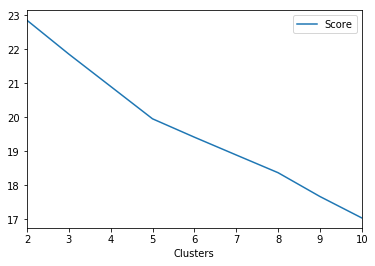

In [204]:
import matplotlib.pyplot as plt
clusterDf.plot(kind='line',x="Clusters",y="Score")
plt.show()

In [205]:
allKMeans = KMeans(n_clusters=5, random_state=0)
allKMeans.fit(allNH_grouped_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [209]:
#combine the string-based datasets

mke_nh_venues_sorted=mke_nh_venues_sorted.drop(columns=["City","Cluster Labels"],axis=1)
pdx_nh_venues_sorted=pdx_nh_venues_sorted.drop(columns=["City","Cluster Labels"],axis=1)
all_nh_venues_sorted ={}

mke_nh_venues_sorted.insert(0,"City","MKE")
pdx_nh_venues_sorted.insert(0,"City","PDX")

all_nh_venues_sorted = mke_nh_venues_sorted.append(pdx_nh_venues_sorted)

all_nh_venues_sorted.insert(0, 'Cluster Labels', allKMeans.labels_)
all_nh_venues_sorted

Cluster Labels City            Neighborhood 1st Most Common Venue  \
0                0  MKE         "The East Side"           Pizza Place   
1                0  MKE       Arlington Heights     Fish & Chips Shop   
2                0  MKE            Avenues West        Sandwich Place   
3                0  MKE                Bay View                   Bar   
4                0  MKE              Beerline B                  Café   
5                0  MKE           Brewers' Hill        Breakfast Spot   
6                0  MKE             Bronzeville   Fried Chicken Joint   
7                0  MKE           Clarke Square    Mexican Restaurant   
8                0  MKE        Cold Spring Park        Cosmetics Shop   
9                0  MKE               East Town                 Hotel   
10               0  MKE            East Village                   Bar   
11               4  MKE            Enderis Park                  Park   
12               0  MKE        Franklin Heights                 Hotel   
13               0  MKE        Grantosa Heights                   Bar   
14               0  MKE               Granville                   Pub   
15               0  MKE          Grover Heights     Convenience Store   
16               0  MKE            Halyard Park            Shoe Store   
17               0  MKE                Harambee              Pharmacy   
18               0  MKE              Havenwoods     Recreation Center   
19               0  MKE  Hillside / Lapham Park               Brewery   
20               0  MKE             Holler Park                 Hotel   
21               4  MKE            Jackson Park            Playground   
22               4  MKE            Jones Island                  Park   
23               0  MKE               Kops Park           Pizza Place   
24               0  MKE             Layton Park    Mexican Restaurant   
25               0  MKE         Lincoln Village    Mexican Restaurant   
26               0  MKE         Lower East Side                   Bar   
27               0  MKE            Martin Drive  Gym / Fitness Center   
28               0  MKE            Merrill Park                   Bar   
29               0  MKE           Metcalfe Park         Grocery Store   
30               0  MKE                 Midtown     Convenience Store   
31               0  MKE              Mount Mary              Pharmacy   
32               0  MKE             Murray Hill     Food & Drink Shop   
33               0  MKE               Park West     Convenience Store   
34               0  MKE               Riverwest                   Bar   
35               0  MKE            Sherman Park   Fried Chicken Joint   
36               0  MKE              Story Hill                  Park   
37               0  MKE          Thurston Woods   Fried Chicken Joint   
38               0  MKE              Tippecanoe    Mexican Restaurant   
39               0  MKE            Town of Lake                   Bar   
40               0  MKE         University Hill        Sandwich Place   
41               0  MKE          Walker's Point    Mexican Restaurant   
42               0  MKE             Walnut Hill                Bakery   
43               0  MKE      Washington Heights                Garden   
44               4  MKE         Washington Park                  Park   
45               0  MKE    Williamsburg Heights              Wine Bar   
0                0  PDX                 Alameda         Garden Center   
1                0  PDX             Arbor Lodge     Convenience Store   
2                0  PDX               Ardenwald  Marijuana Dispensary   
3                0  PDX                   Argay       Thai Restaurant   
4                0  PDX       Arlington Heights                Garden   
5                0  PDX            Arnold Creek            Restaurant   
6                4  PDX               Ash Creek                  Park   
7                0  PDX       Beaumont Wilshire           Pizz

### Cluster 1

In [212]:
all_nh_venues_sorted.loc[all_nh_venues_sorted['Cluster Labels'] == 0,all_nh_venues_sorted.columns[[0] + list(range(1,all_nh_venues_sorted.shape[1]))]]

Cluster Labels City            Neighborhood 1st Most Common Venue  \
0                0  MKE         "The East Side"           Pizza Place   
1                0  MKE       Arlington Heights     Fish & Chips Shop   
2                0  MKE            Avenues West        Sandwich Place   
3                0  MKE                Bay View                   Bar   
4                0  MKE              Beerline B                  Café   
5                0  MKE           Brewers' Hill        Breakfast Spot   
6                0  MKE             Bronzeville   Fried Chicken Joint   
7                0  MKE           Clarke Square    Mexican Restaurant   
8                0  MKE        Cold Spring Park        Cosmetics Shop   
9                0  MKE               East Town                 Hotel   
10               0  MKE            East Village                   Bar   
12               0  MKE        Franklin Heights                 Hotel   
13               0  MKE        Grantosa Heights                   Bar   
14               0  MKE               Granville                   Pub   
15               0  MKE          Grover Heights     Convenience Store   
16               0  MKE            Halyard Park            Shoe Store   
17               0  MKE                Harambee              Pharmacy   
18               0  MKE              Havenwoods     Recreation Center   
19               0  MKE  Hillside / Lapham Park               Brewery   
20               0  MKE             Holler Park                 Hotel   
23               0  MKE               Kops Park           Pizza Place   
24               0  MKE             Layton Park    Mexican Restaurant   
25               0  MKE         Lincoln Village    Mexican Restaurant   
26               0  MKE         Lower East Side                   Bar   
27               0  MKE            Martin Drive  Gym / Fitness Center   
28               0  MKE            Merrill Park                   Bar   
29               0  MKE           Metcalfe Park         Grocery Store   
30               0  MKE                 Midtown     Convenience Store   
31               0  MKE              Mount Mary              Pharmacy   
32               0  MKE             Murray Hill     Food & Drink Shop   
33               0  MKE               Park West     Convenience Store   
34               0  MKE               Riverwest                   Bar   
35               0  MKE            Sherman Park   Fried Chicken Joint   
36               0  MKE              Story Hill                  Park   
37               0  MKE          Thurston Woods   Fried Chicken Joint   
38               0  MKE              Tippecanoe    Mexican Restaurant   
39               0  MKE            Town of Lake                   Bar   
40               0  MKE         University Hill        Sandwich Place   
41               0  MKE          Walker's Point    Mexican Restaurant   
42               0  MKE             Walnut Hill                Bakery   
43               0  MKE      Washington Heights                Garden   
45               0  MKE    Williamsburg Heights              Wine Bar   
0                0  PDX                 Alameda         Garden Center   
1                0  PDX             Arbor Lodge     Convenience Store   
2                0  PDX               Ardenwald  Marijuana Dispensary   
3                0  PDX                   Argay       Thai Restaurant   
4                0  PDX       Arlington Heights                Garden   
5                0  PDX            Arnold Creek            Restaurant   
7                0  PDX       Beaumont Wilshire           Pizza Place   
8                0  PDX                   Boise           Pizza Place   
10               0  PDX               Bridgeton       Harbor / Marina   
12               0  PDX                Brooklyn                   Bar   
13               0  PDX                 Buckman           Coffee Shop   
14               0  PDX          Cathedral Park           Coff

### Cluster 2

In [213]:
all_nh_venues_sorted.loc[all_nh_venues_sorted['Cluster Labels'] == 1,all_nh_venues_sorted.columns[[0] + list(range(1,all_nh_venues_sorted.shape[1]))]]

Cluster Labels City     Neighborhood 1st Most Common Venue  \
24               1  PDX     Eastmoreland                  Park   
29               1  PDX         Glenfair                  Park   
31               1  PDX       Grant Park                  Park   
67               1  PDX  Pleasant Valley                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
24           Zoo Exhibit           Flower Shop           Flea Market   
29           Zoo Exhibit           Flower Shop           Flea Market   
31           Zoo Exhibit           Flower Shop           Flea Market   
67         Event Service           Zoo Exhibit           Flower Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
24           Fish Market  Fast Food Restaurant        Farmers Market   
29           Fish Market  Fast Food Restaurant        Farmers Market   
31           Fish Market  Fast Food Restaurant        Farmers Market   
67           Flea Market           Fish Market  Fast Food Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
24                  Farm            Eye Doctor            Event Space  
29                  Farm            Eye Doctor            Event Space  
31                  Farm            Eye Doctor            Event Space  
67        Farmers Market                  Farm             Eye Doctor

### Cluster 3

In [214]:
all_nh_venues_sorted.loc[all_nh_venues_sorted['Cluster Labels'] == 2,all_nh_venues_sorted.columns[[0] + list(range(1,all_nh_venues_sorted.shape[1]))]]

Cluster Labels City Neighborhood 1st Most Common Venue  \
27               2  PDX  Forest Park                 Trail   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
27           Zoo Exhibit            Eye Doctor     Electronics Store   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
27     Elementary School  Ethiopian Restaurant         Event Service   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
27           Event Space                  Farm              Drugstore

### Cluster 4

In [215]:
all_nh_venues_sorted.loc[all_nh_venues_sorted['Cluster Labels'] == 3,all_nh_venues_sorted.columns[[0] + list(range(1,all_nh_venues_sorted.shape[1]))]]

Cluster Labels City  Neighborhood 1st Most Common Venue  \
17               3  PDX  Collins View    Photography Studio   

   2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
17           Zoo Exhibit           Event Space  Eastern European Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
17     Electronics Store     Elementary School  Ethiopian Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
17         Event Service            Eye Doctor             Donut Shop

### Cluster 5

In [216]:
all_nh_venues_sorted.loc[all_nh_venues_sorted['Cluster Labels'] == 4,all_nh_venues_sorted.columns[[0] + list(range(1,all_nh_venues_sorted.shape[1]))]]

Cluster Labels City          Neighborhood 1st Most Common Venue  \
11               4  MKE          Enderis Park                  Park   
21               4  MKE          Jackson Park            Playground   
22               4  MKE          Jones Island                  Park   
44               4  MKE       Washington Park                  Park   
6                4  PDX             Ash Creek                  Park   
9                4  PDX  Brentwood Darlington                  Park   
11               4  PDX            Bridlemile                  Park   
23               4  PDX         East Columbia                Casino   
33               4  PDX              Hayhurst      Recording Studio   
35               4  PDX         Healy Heights                  Park   
37               4  PDX              Hillside                 Trail   
51               4  PDX             Maplewood                  Park   
60               4  PDX     Northwest Heights                  Park   
74               4  PDX               Russell                  Food   
87               4  PDX    West Portland Park                  Park   

   2nd Most Common Venue       3rd Most Common Venue  \
11            Playground              Farmers Market   
21                  Park                        Pool   
22       Harbor / Marina                 Yoga Studio   
44  Other Great Outdoors                         Bar   
6            Salad Place  Construction & Landscaping   
9                Dog Run                    Bus Stop   
11          Tennis Court                 Event Space   
23                  Park             Auto Dealership   
33                  Park                 Zoo Exhibit   
35                 Trail                 Event Space   
37                  Park                      Museum   
51        Baseball Field                 Coffee Shop   
60      Business Service                Soccer Field   
74                  Park                 Event Space   
87        Cosmetics Shop              Sandwich Place   

          4th Most Common Venue        5th Most Common Venue  \
11          Sporting Goods Shop                       Office   
21               History Museum                     Dive Bar   
22          Dumpling Restaurant                         Food   
44                  Yoga Studio          Empanada Restaurant   
6                Cosmetics Shop                    Drugstore   
9                 Deli / Bodega                   Eye Doctor   
11  Eastern European Restaurant            Electronics Store   
23                         Food                  Fish Market   
33                Event Service                    Drugstore   
35  Eastern European Restaurant            Electronics Store   
37               Scenic Lookout                          Gym   
51                  Flea Market                  Fish Market   
60                Event Service  Eastern European Restaurant   
74                    Drugstore  Eastern European Restaurant   
87         Gym / Fitness Center                Event Service   

          6th Most Common Venue        7th Most Common Venue  \
11                Grocery Store           Salon / Barbershop   
21            Fish & Chips Shop         Fast Food Restaurant   
22                  Flower Shop            Fish & Chips Shop   
44            Food & Drink Shop                         Food   
6                   Flower Shop                  Flea Market   
9             Elementary School         Ethiopian Restaurant   
11            Elementary School         Ethiopian Restaurant   
23         Fast Food Restaurant               Farmers Market   
33  Eastern European Restaurant            Electronics Store   
35            Elementary School         Ethiopian Restaurant   
37                  Music Venue                   Eye Doctor   
51         Fast Food Restaurant               Farmers Market   
60            Electronics Store            Elementary School   
74            Electronics Store            Elemen

In [228]:
pdx_describe = pdx_grouped.describe()
pdx_val = pdx_describe.sort_values('mean', axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')
pdx_val

Park  Coffee Shop        Bar  Pizza Place   Bus Stop  Food Truck  \
count  92.000000    92.000000  92.000000    92.000000  92.000000   92.000000   
mean    0.101710     0.047697   0.029950     0.029116   0.025825    0.022839   
std     0.216040     0.068275   0.068410     0.063514   0.068929    0.064804   
min     0.000000     0.000000   0.000000     0.000000   0.000000    0.000000   
25%     0.000000     0.000000   0.000000     0.000000   0.000000    0.000000   
50%     0.000000     0.000000   0.000000     0.000000   0.000000    0.000000   
75%     0.085227     0.073206   0.037037     0.040000   0.010441    0.017317   
max     1.000000     0.333333   0.500000     0.500000   0.428571    0.500000   

       Mexican Restaurant      Trail  Convenience Store  Grocery Store  \
count           92.000000  92.000000          92.000000      92.000000   
mean             0.022369   0.021735           0.021076       0.016224   
std              0.051638   0.120936           0.052353       0.036438   
min              0.000000   0.000000           0.000000       0.000000   
25%              0.000000   0.000000           0.000000       0.000000   
50%              0.000000   0.000000           0.000000       0.000000   
75%              0.024390   0.000000           0.000000       0.012311   
max              0.333333   1.000000           0.250000       0.200000   

       Thai Restaurant  Sandwich Place  American Restaurant  Playground  \
count        92.000000       92.000000            92.000000   92.000000   
mean          0.015753        0.013464             0.012697    0.011988   
std           0.065666        0.034926             0.037868    0.064318   
min           0.000000        0.000000             0.000000    0.000000   
25%           0.000000        0.000000             0.000000    0.000000   
50%           0.000000        0.000000             0.000000    0.000000   
75%           0.000000        0.010549             0.000000    0.000000   
max           0.600000        0.250000             0.250000    0.500000   

             Gym  Gas Station  Photography Studio  College Cafeteria  \
count  92.000000    92.000000           92.000000          92.000000   
mean    0.011688     0.011392            0.010870           0.010870   
std     0.054664     0.046801            0.104257           0.104257   
min     0.000000     0.000000            0.000000           0.000000   
25%     0.000000     0.000000            0.000000           0.000000   
50%     0.000000     0.000000            0.000000           0.000000   
75%     0.000000     0.000000            0.000000           0.000000   
max     0.500000     0.333333            1.000000           1.000000   

            Café       Food  Marijuana Dispensary  Clothing Store     Garden  \
count  92.000000  92.000000             92.000000       92.000000  92.000000   
mean    0.010478   0.010242              0.009794        0.008884   0.008867   
std     0.020906   0.060336              0.030969        0.028273   0.044622   
min     0.000000   0.000000              0.000000        0.000000   0.000000   
25%     0.000000   0.000000              0.000000        0.000000   0.000000   
50%     0.000000   0.000000              0.000000        0.000000   0.000000   
75%     0.000000   0.000000              0.000000        0.000000   0.000000   
max     0.083333   0.500000              0.166667        0.166667   0.333333   

       Restaurant  Tennis Court    Brewery      Hotel  Chinese Restaurant  \
count   92.000000     92.000000  92.000000  92.000000           92.000000   
mean     0.008753      0.008724   0.008122   0.007909            0.007435   
std      0.039829      0.058203   0.023544   0.028165            0.037575   
min      0.000000      0.000000   0.000000   0.000000            0.000000   
25%      0.000000      0.000000   0.000000   0.000000            0.000000   
50%      0.000000      0.000000   0.000000   0.000000            0.000000   
75%      0.000000      0.000000   0.000

In [229]:
mke_describe = mke_grouped.describe()
mke_val = mke_describe.sort_values('mean', axis=1, ascending=False, inplace=False, kind='quicksort', na_position='last')
mke_val

Bar       Park  Mexican Restaurant  Liquor Store  Grocery Store  \
count  46.000000  46.000000           46.000000     46.000000      46.000000   
mean    0.075018   0.060067            0.039497      0.034465       0.029330   
std     0.105312   0.118154            0.076499      0.067200       0.070016   
min     0.000000   0.000000            0.000000      0.000000       0.000000   
25%     0.000000   0.000000            0.000000      0.000000       0.000000   
50%     0.022195   0.000000            0.000000      0.000000       0.000000   
75%     0.121528   0.063889            0.041250      0.024201       0.024231   
max     0.500000   0.500000            0.277778      0.250000       0.333333   

       Convenience Store  Sandwich Place  Pizza Place  Recreation Center  \
count          46.000000       46.000000    46.000000          46.000000   
mean            0.028598        0.026114     0.025162           0.024909   
std             0.077214        0.067451     0.046502           0.147747   
min             0.000000        0.000000     0.000000           0.000000   
25%             0.000000        0.000000     0.000000           0.000000   
50%             0.000000        0.000000     0.000000           0.000000   
75%             0.000000        0.000000     0.033542           0.000000   
max             0.333333        0.333333     0.200000           1.000000   

       Cosmetics Shop  American Restaurant  Fried Chicken Joint   Pharmacy  \
count       46.000000            46.000000            46.000000  46.000000   
mean         0.023088             0.018349             0.017341   0.017092   
std          0.079300             0.043229             0.052319   0.047369   
min          0.000000             0.000000             0.000000   0.000000   
25%          0.000000             0.000000             0.000000   0.000000   
50%          0.000000             0.000000             0.000000   0.000000   
75%          0.000000             0.000000             0.000000   0.000000   
max          0.500000             0.200000             0.250000   0.250000   

       Video Store     Lounge  Coffee Shop    Brewery       Café  \
count    46.000000  46.000000    46.000000  46.000000  46.000000   
mean      0.016588   0.015302     0.015240   0.015084   0.014489   
std       0.056387   0.044903     0.027614   0.043789   0.031196   
min       0.000000   0.000000     0.000000   0.000000   0.000000   
25%       0.000000   0.000000     0.000000   0.000000   0.000000   
50%       0.000000   0.000000     0.000000   0.000000   0.000000   
75%       0.000000   0.000000     0.020270   0.000000   0.000000   
max       0.333333   0.250000     0.090909   0.266667   0.125000   

       Salon / Barbershop      Hotel       Bank  Fast Food Restaurant  \
count           46.000000  46.000000  46.000000             46.000000   
mean             0.013918   0.013864   0.013469              0.013355   
std              0.046126   0.046172   0.039193              0.045064   
min              0.000000   0.000000   0.000000              0.000000   
25%              0.000000   0.000000   0.000000              0.000000   
50%              0.000000   0.000000   0.000000              0.000000   
75%              0.000000   0.000000   0.000000              0.000000   
max              0.250000   0.200000   0.200000              0.250000   

       Playground  Harbor / Marina  Flower Shop  Restaurant     Bakery  \
count   46.000000        46.000000    46.000000   46.000000  46.000000   
mean     0.012008         0.011646     0.011336    0.011179   0.010975   
std      0.052316         0.073792     0.043093    0.025485   0.042700   
min      0.000000         0.000000     0.000000    0.000000   0.000000   
25%      0.000000         0.000000     0.000000    0.000000   0.000000   
50%      0.000000         0.000000     0.000000    0.000000   0.000000   
75%      0.000000         0.000000     0.000000    0.000000   0.000000   
max      0.333333         0.500000     0.